# 【双归一化网络】数据处理为特征向量并存储起来

## 20230519log

* 【步骤】
    * 基于2.2数据预处理1.ipynb。
    * 引入Dino预训练后的编码器，对数据进行编码
    * 编码后保存在内存的一个tensor中

* 【描述】读取Data_raw中的txt数据，经过Dino预训练的ViT编码器，将其按照步长编码，存入tensor。最后存入Matching_fea文件夹
* 【描述】可选加载上次的网格，在Matching_map_raw中

## 20230528log

* 【特性】加入EEnT支持
* 【使用】
    * 1 更改需要编码的地图txt路径，如“太平洋1.txt”
    * 2 更改使用的架构与与训练权重路径
        * "--arch"参数：如BiNet_NO1、EEnT_tiny_NO1
        * "--num_ele_slice"参数，确保与选择的预训练权重中的，切片数一致
        * "--pretrained_weights"参数：保存的预训练权重路径
        * net_name 变量：影响保存文件名，建议更改
    * 3 编码新地图时，确保load_grid为false，进行重新编码，否则会找不到地图。

In [9]:
from Py01shared_code import get_host_name_DINO_X, AddGaussianNoise, AddGaussianNoise_Pre_Snr
from Py04Model_load import load_Pre_ViT_No1, get_args, dataset_from_geoTXT, extract_features_geoTXT
from Py05_Matching_fun import idx2xy, xy2idx, dataset_from_geoTXT_aug_BiNorm, dataset_from_geoTXT_aug_BiNorm_BiAug, feature_normalize, minmaxscaler
from Py05_Matching_fun import dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_Resize
from Py05_Matching_fun import dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_for_DYNA
from Py06BiNet import load_Pre_BiNet_No1, extract_features_geoTXT_Bi, get_global_norm, get_local_aug, load_Pre_BiNet_Res_NO1
from Py07EEnT import load_Pre_EEnT_tiny_No1
from Py08EEnT_NO2 import EEnT_NO2_tiny, load_Pre_EEnT_NO2_tiny
import Py10Bi_model
from Py11_Aug_self import MuskApply, MuskApply_tensor
from Py13_SA_FETM import get_bof_Pacific_voc

In [10]:
import os
import torch
os.makedirs(os.path.join('..','data'),exist_ok=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import sys
from PIL import Image
# print(data)

In [11]:
import utils
import torch.distributed as dist
from torchvision import transforms as pth_transforms
import datetime

## 参数

In [12]:
# 定义裁剪形状和步长
shape = (224, 224)

crop_shape = (224, 224)
out_shape = (224, 224)
stride = 1
mask_size = m_temp_outside#  m_temp_outside # 50 # 224 # 20
pad_mode = "constant" # constant为0填充、‘mean’——表示均值填充、‘median’——表示中位数

In [13]:
strid_test = 30 # 30 ,50
step = 1 # 网格大小为1
ex_range = 50

In [14]:
args_self=[
# "--data_path","./Data_geo/Matching_test_high80/匹配test-high80",
# '--box_label_path',"./Data_geo/Matching_test_high80/【Label】匹配test-high80.csv",
# "--load_features","./dump_features", # 注释与否决定是否从文件加载特征
"--pretrained_weights", "./【checkpoint存档】/20230621【BiNet_Res_NO1】_01【base】.pth",
# "--pretrained_weights", "./checkpoint.pth",
# "--arch", "BiNet_NO1"
'--batch_size_per_gpu', "128", # 默认128
'--arch', "BiNet_Res_NO1", # 一般可选BiNet_NO1、EEnT_tiny_NO1、EEnT_tiny_NO2, BiNet_Res_NO1, TBiNet_Res_NO2_bi
"--num_ele_slice", "20000", # 专为EEnT中的高程嵌入使用的参数
"--num_workers", "10"
]
args = get_args(args_self)

# print("长度为：")
# print(sys.argv)
# # try:
# if len(sys.argv) != 3:
#     args.arch = sys.argv[3]
#     args.pretrained_weights = sys.argv[4]
#     net_name = sys.argv[5]
#     print("参数已通过命令行修改：")
#     print(args.arch)
#     print(args.pretrained_weights)
#     print(net_name)
# # except:
# #     pass

In [19]:
t_prefix = datetime.date.today().strftime('%Y%m%d')
# t_prefix = "20230701"
map_name = "太平洋1.txt" # 太平洋1.txt，test1.txt，极地5.txt、印度洋1.txt、大西洋1.txt
# map_name = "大连海图数据.txt"
grid_info = "grid_" + str(step)
save_dir = "./Matching_fea/"
# net_name = "【BiNet_Res_NO1】" + "_"
# mask_info = "mask_size" + str(mask_size) + "_"
# mask_info = "temp"
addtion_info = "" + "mask_size_" + str(mask_size)
host_name = get_host_name_DINO_X()

# output_name = t_prefix + map_name[0:-4] + grid_info + net_name + mask_info +  "fea_" + addtion_info + host_name + ".pth"# "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
weigh_name = os.path.basename(args.pretrained_weights)[0:-4]
output_name = "【FEA】" + map_name[0:-4] + "_" + weigh_name   + "_" + grid_info  + addtion_info + host_name 
save_file_path = save_dir + output_name
load_grid = True # 是否读取划分好的网格节省时间
# save_file_path = "./Matching_fea/太平洋1_GRET_ELE_DB_NO2_bi_fea_mask20.pth"
######## 临时保存名称#####################
output_name = "【FEA】" + map_name[0:-4] + args.arch +  "fea" +  ".pth" # "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
save_file_path = save_dir + output_name
###########################
print(save_file_path)


./Matching_fea/【FEA】大西洋1_20230624【BiNet_Res_NO1】_01_无增强_grid_1mask_size_20DINO_3


# 参数替换

* 如果从外部运行，且使用了其命名空间，可以通过检查某些变量是否存在来判断，是直接运行还是从外部运行

In [8]:
try:
    print("pre_model_path_outside = ", pre_model_path_outside)
#     net_name_outside
    print("arch_outside = ", arch_outside)
    print("num_ele_slice_outside = ", num_ele_slice_outside)
except NameError: # 外部定义变量不存在，使用本地，do noting
    print("外部变量不存在，使用【本地变量】")
#     var_exists = False
else: # 外部变量存在，使用外部：替换
    print("外部变量存在，使用【外部配置】")
    args.pretrained_weights = pre_model_path_outside
    args.arch = arch_outside
#     net_name = net_name_outside
    output_name = "【FEA】" + map_name[0:-4] + args.arch +  "fea" +  ".pth" # "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
    save_file_path = save_dir + output_name
    # 同时减小batchsize避免出错
    args.batch_size_per_gpu = 128
    args.num_ele_slice = num_ele_slice_outside
#     var_exists = True

外部变量不存在，使用【本地变量】


# txt格式数据读取与可视化

In [9]:
data_file = os.path.join("./Data_raw/", map_name)
data = pd.read_csv(data_file)

In [10]:
xx,yy,zz = data.iloc[:, 0],data.iloc[:, 1],data.iloc[:, 2]
# xx.shape
# 对Series对象进行排名和替换
xx = xx.rank(method='dense').astype(int)
yy = yy.rank(method='dense').astype(int)
zz = zz.fillna(0)

zz =torch.tensor(zz.values)

xx.shape,yy.shape,zz.shape

((4245875,), (4245875,), torch.Size([4245875]))

In [11]:
xx

0             1
1             1
2             1
3             1
4             1
           ... 
4245870    1999
4245871    1999
4245872    1999
4245873    1999
4245874    1999
Name: -64.1728684839, Length: 4245875, dtype: int64

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import griddata


# 确定网格化范围
x_min, x_max = np.min(xx), np.max(xx)
y_min, y_max = np.min(yy), np.max(yy)



map_save_path = "./Matching_map_raw/" + map_name[0:-4] + "_gridsize" + str(step) + ".pth"

if load_grid : # and os.path.exists("./Matching_map_raw/" + "map_raw" + output_name)
#     x,y,z = torch.load("./Matching_map_raw/" + "map_raw_" + output_name)
    x,y,z = torch.load(map_save_path)
    print("已存储网格载入成功")
    print(map_save_path)
else:
    print("绘制并存储网格")
    print(map_save_path)

    # 生成网格
    x,y = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    # 对高程数据进行插值
    z = griddata((xx, yy), zz, (x,y), method='cubic')

    z.shape
    torch.save((x,y,z), map_save_path)
global_min = z.min()
global_max = z.max()
print("global_min = " + str(global_min))
print("global_max = " + str(global_max))
print("z.shape = " + str(z.shape))

绘制并存储网格
./Matching_map_raw/大西洋1_gridsize1.pth
global_min = -6795.679
global_max = -1350.016
z.shape = (2123, 1998)


In [13]:
x.shape

(2123, 1998)

In [14]:
# per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
# per_li[-1] = 1
# print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
# print(per_li)

In [15]:
# per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
# per_li_var[-1] = 1
# print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# # print(per_li)

In [16]:
per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
per_li = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li = (per_li - global_min) / (global_max - global_min)
per_li[-1] = 1
print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
print(per_li)

已读取分位数列表：per_li， 份数20000
[0.         0.01991502 0.0266243  ... 0.95779773 0.97585286 1.        ]


In [17]:
per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
per_li_var = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li_var = (per_li_var - global_min) / (global_max - global_min)
per_li_var[-1] = 1
print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li_var， 份数20000


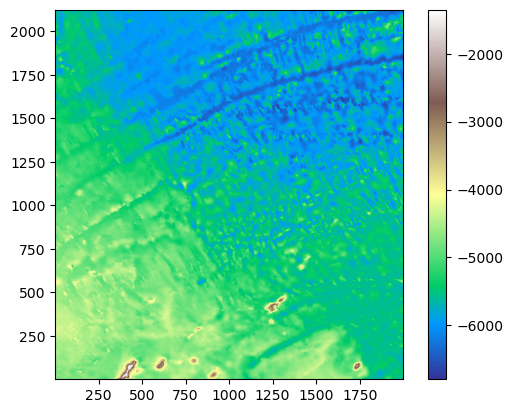

In [18]:
# 可视化网格数据
plt.imshow(z, cmap='terrain', extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.show()

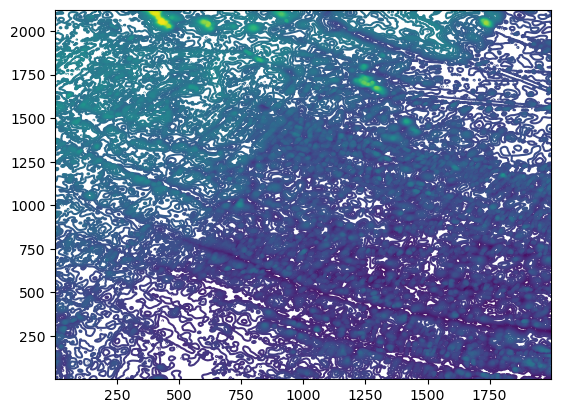

In [19]:
# 绘制等高线图
fig, ax = plt.subplots()
num_level = 50
level_li = np.linspace(z.min(), z.max(), num_level)
a = ax.contour(x, y, z, level_li) # 或者直接传入num_level，或传入一个等间隔的list

# 添加等高线标签
# ax.clabel(a, inline=True, fontsize=10)
# plt.savefig('./【NB25】适配性结果/' + map_name[0:-4] + "_levelnum_" + str(num_level) + '.tiff', dpi = 300)
# 显示图形
plt.show()

# 编码与保存特征

In [20]:
try:
    utils.init_distributed_mode(args)
except:
    print("已经启动，不再重复")
    pass

Will run the code on one GPU.
| distributed init (rank 0): env://


## 创建数据集：切分方案

* 传入一张图的信息，然后从中截取图片，再跑前向

In [21]:
# # 无mask的编码
# transform_for_DB = pth_transforms.Compose([
# #     pth_transforms.Resize(256, interpolation=3),
# #     pth_transforms.CenterCrop(224),
# #     pth_transforms.GaussianBlur(kernel_size = 21, sigma = 1.0),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm(z, shape, stride, transform_for_DB, global_min, global_max) # 无mask编码

In [22]:
# 有mask的编码
transform_for_DB = pth_transforms.Compose([
    MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485], std=[0.229]),
])

transform_for_global_DB = pth_transforms.Compose([
    # MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
    pth_transforms.CenterCrop(mask_size),
    pth_transforms.ToTensor(),
])

# 有mask编码 
dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug(z, shape, stride, transform_for_DB, transform_for_global_DB, global_min, global_max) # 有mask编码

In [23]:
# # 【测试5】在转为图像之前，就加入高斯噪声。（仍为图像方案，可能会损失精度，实验目的只是测试统一信噪比增强，对小尺寸与大尺寸上，会不会有理想的结果）
# Gauss_aug_Obj = AddGaussianNoise_Pre_Snr(mean=0, variance=1, snr=1.0) # 等于一相当于不做
# transform_for_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug(z, crop_shape, (224,224), stride, Gauss_aug_Obj, transform_for_match, transform_for_global_match, global_min, global_max)

In [24]:
# # 【测试6】彻底不使用图像化增强(与7，使用resize而不是padding)
# Gauss_aug_Obj = AddGaussianNoise_Pre_Snr(mean=0, variance=1, snr=1.0) # 等于一相当于不做
# # Gauss_aug_Obj = AddGaussianNoise_Pre(mean=0, variance=1, amplitude=0)
# transform_for_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize(mean=[0.485], std=[0.229]),
# ])

# transform_for_global_match = pth_transforms.Compose([
# #     MuskApply(mask_size = mask_size, mode=pad_mode),  # “constant”为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# #     AddGaussianNoise(mean=0, variance=1, amplitude=10),
#     pth_transforms.ToTensor(),
# ])
# # print(stride)
# # 无mask编码
# dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG(z, crop_shape, (224,224), stride, Gauss_aug_Obj, transform_for_match, transform_for_global_match, global_min, global_max)

In [25]:
dataset_geo_for_dyna = dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_for_DYNA(z, crop_shape, out_shape, stride, global_min, global_max)
dataset_len = dataset_geo_for_dyna.__len__()
s_num = int(dataset_len * 0.9)
if s_num > 20000:
    s_num = 20000
print("测试数量：" + str(s_num) )
select_li = np.random.choice(dataset_len, s_num, replace=False)
select_li = [int(item) for item in select_li] # 转为list
dynamic_sum = 0
for i, idx in enumerate(select_li):
    data,_,_ = dataset_geo_for_dyna.__getitem__(idx)
    dy_now = np.nanmax(data.numpy()) - np.nanmin(data.numpy())
    dynamic_sum += dy_now
#     print(dy_now)
dynamic_avg = dynamic_sum / s_num
print("crop_shape = " + str(crop_shape))
print("map_name = " + str(map_name))
print("grid_size = " + str(step))
print("动态范围均值dynamic_avg为：" + str(dynamic_avg))

测试数量：20000
crop_shape = (224, 224)
map_name = 大西洋1.txt
grid_size = 1
动态范围均值dynamic_avg为：1498.7564035888672


In [26]:
# 获取bof特征
load_bof_voc = True
if load_bof_voc:
    bof_voc, bof_stdSlr = torch.load("./bof_voc/voc_Pacific.pth")
    voc_k = bof_voc.shape[0]
    print("voc_k = ", voc_k, " (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)")
    print("成功加载bof_voc")
else:
    voc_k = 100
    bof_voc, bof_stdSlr = get_bof_Pacific_voc(dataset_geo, using_num = 2000, voc_k = voc_k)
    torch.save((bof_voc, bof_stdSlr), "./bof_voc/voc_Pacific.pth")

voc_k =  100  (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)
成功加载bof_voc


In [27]:
# dataset_geo = dataset_from_geoTXT(z, shape, stride)
# dataset_geo.__getitem__(0)

sampler = torch.utils.data.DistributedSampler(dataset_geo, shuffle=False)
data_loader_train = torch.utils.data.DataLoader(
    dataset_geo,
    sampler=sampler,
    batch_size=args.batch_size_per_gpu,
#     batch_size = 256,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False,
)
# metric_logger = utils.MetricLogger(delimiter="  ")
# for samples, index, box in metric_logger.log_every(data_loader_train, 10):
#     print(1)
#     break

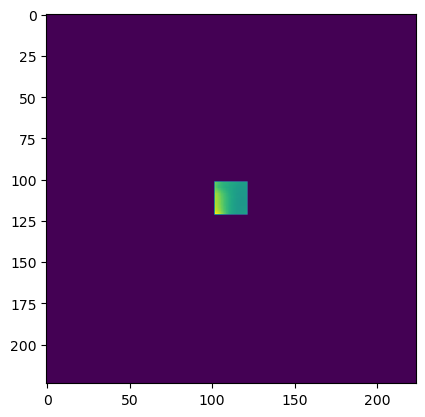

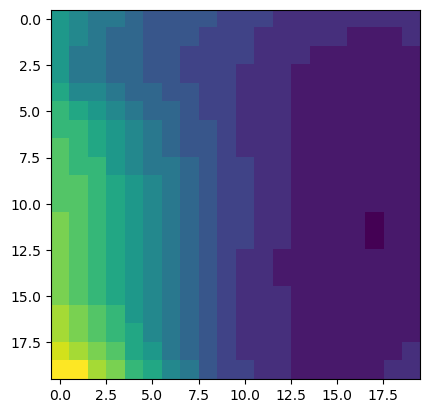

In [28]:
data,data_g,_,_ = dataset_geo.__getitem__(1000)
plt.imshow(data.squeeze())
plt.show()
plt.imshow(data_g.squeeze())
plt.show()

## 模型加载

In [29]:

assert os.path.exists(args.pretrained_weights), "权重不存在，检查路径"
# model = load_Pre_ViT_No1(args)
if args.arch == "BiNet_NO1":
    model = load_Pre_BiNet_No1(args)
elif args.arch == "EEnT_tiny_NO1":
    model = load_Pre_EEnT_tiny_No1(args)
elif args.arch == "EEnT_tiny_NO2":
    model = load_Pre_EEnT_NO2_tiny(args, per_li = per_li)
    embed_dim = model.embed_dim
elif args.arch == "BiNet_Res_NO1":
    model = load_Pre_BiNet_Res_NO1(args)
    embed_dim = model.embed_dim
elif args.arch in Py10Bi_model.__dict__.keys():
    try:
        model = Py10Bi_model.__dict__[args.arch]() # 调用函数
        print("模型" + args.arch + "创建成功")
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
    except:
        model = Py10Bi_model.__dict__[args.arch](num_ele_slice=args.num_ele_slice, per_li=per_li, per_li_var=per_li_var,
                                           bof_voc=bof_voc, bof_stdSlr=bof_stdSlr, in_chans=1, voc_k = voc_k,
                                          g_min = global_min, g_max = global_max)
        embed_dim = model.embed_dim
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
else:
    assert 0, "不支持的模型"

Take key teacher in provided checkpoint dict
Pretrained weights found at ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
预训练模型加载成功


## 编码返回Feature

In [30]:
@torch.no_grad()
def extract_features_geoTXT_Bi(model, data_loader, use_cuda=True, multiscale=False):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    for samples, samples_g_norm, index, box in metric_logger.log_every(data_loader, 100):
#         print(samples.shape)
#         samples_global_norm = get_global_norm(samples, global_min, global_max).cuda(non_blocking=True)
#         samples_local_norm = get_local_aug(samples, transform).cuda(non_blocking=True)
#         samples_global_norm = samples_global_norm.cuda(non_blocking=True)
        samples = samples.cuda(non_blocking=True)
        samples_g_norm = samples_g_norm.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)
        if multiscale:
            feats = utils.multi_scale(samples, model)
        else:
            with torch.no_grad():
                feats = model(samples, samples_g_norm).clone()

        # init storage feature matrix
        if dist.get_rank() == 0 and features is None:
            features = torch.zeros(len(data_loader.dataset), feats.shape[-1])
            if use_cuda:
                features = features.cuda(non_blocking=True)
            print(f"Storing features into tensor of shape {features.shape}")

        # get indexes from all processes
        y_all = torch.empty(dist.get_world_size(), index.size(0), dtype=index.dtype, device=index.device)
        y_l = list(y_all.unbind(0))
        y_all_reduce = torch.distributed.all_gather(y_l, index, async_op=True)
        y_all_reduce.wait()
        index_all = torch.cat(y_l)

        # share features between processes
        feats_all = torch.empty(
            dist.get_world_size(),
            feats.size(0),
            feats.size(1),
            dtype=feats.dtype,
            device=feats.device,
        )
        output_l = list(feats_all.unbind(0))
        output_all_reduce = torch.distributed.all_gather(output_l, feats, async_op=True)
        output_all_reduce.wait()
        
        if index[0] % 10000 == 0:
            print("Processed:" + str(index[0]))
        
#         print(index)
        # update storage feature matrix
        if dist.get_rank() == 0:
            if use_cuda:
                features.index_copy_(0, index_all, torch.cat(output_l))
            else:
                features.index_copy_(0, index_all.cpu(), torch.cat(output_l).cpu())
    return features

In [31]:
fea = extract_features_geoTXT_Bi(model, data_loader_train)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Storing features into tensor of shape torch.Size([3372500, 195])
Processed:tensor(0, device='cuda:0')
  [    0/26348]  eta: 1 day, 5:55:04    time: 4.087761  data: 2.665095  max mem: 2587
  [  100/26348]  eta: 1:15:16    time: 0.138558  data: 0.000240  max mem: 3004
  [  200/26348]  eta: 1:06:14    time: 0.127216  data: 0.000195  max mem: 3004
  [  300/26348]  eta: 1:02:51    time: 0.131697  data: 0.000418  max mem: 3004
  [  400/26348]  eta: 1:01:00    time: 0.128525  data: 0.000205  max mem: 3004
  [  500/26348]  eta: 1:00:07    time: 0.130439  data: 0.000214  max mem: 3004
  [  600/26348]  eta: 0:59:13    time: 0.127639  data: 0.000237  max mem: 3004
Processed:tensor(80000, device='cuda:0')
  [  700/26348]  eta: 0:59:45    time: 0.145369  data: 0.000192  max mem: 3004
  [  800/26348]  eta: 0:59:00    time: 0.133808  data: 0.000220  max mem: 3004
  [ 1800/26348]  eta: 0:54:54    time: 0.128049  data: 0.000210  max mem: 3004
Processed:tensor(240000, device='cuda:0')
  [ 1900/26348]  e

## 保存tensor

In [32]:
fea.shape 
torch.save(fea, save_file_path)

# 测试读取

In [33]:
fea = torch.load(save_file_path)

# 截取其中一部分做可视化

In [34]:
shape = (224, 224)
stride_test = 20 # 224
# ex_range = 50 # 先验范围

n_rows = (z.shape[0] - shape[0]) // stride + 1
n_cols = (z.shape[1] - shape[1]) // stride + 1
n_matrices = n_rows * n_cols

n_rows_test = (z.shape[0] - shape[0]) // stride_test + 1
n_cols_test = (z.shape[1] - shape[1]) // stride_test + 1
n_matrices_test = n_rows_test * n_cols_test
# n_rows + 112
print(str((n_rows_test, n_cols_test, n_matrices_test)))

(95, 89, 8455)


In [35]:
print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test))
select_fea = torch.zeros([n_matrices_test, fea.shape[1]])
for i in range(n_rows_test):
    for j in range(n_cols_test):
        str_log = "Selected num: [" + str(i*n_cols_test+j) +"/" + str(n_matrices_test) + "]"
        start_i = i * stride_test
        start_j = j * stride_test
        # 计算中心点坐标
        center_i = start_i + shape[0] // 2
        center_j = start_j + shape[1] // 2
        # 转换为1步长的idx，便于检索
        idx_real = xy2idx(center_i, center_j, n_rows, n_cols)
        select_fea[(i*n_cols_test+j), :] = fea[idx_real ,:]

测试数量：95*89 = 8455


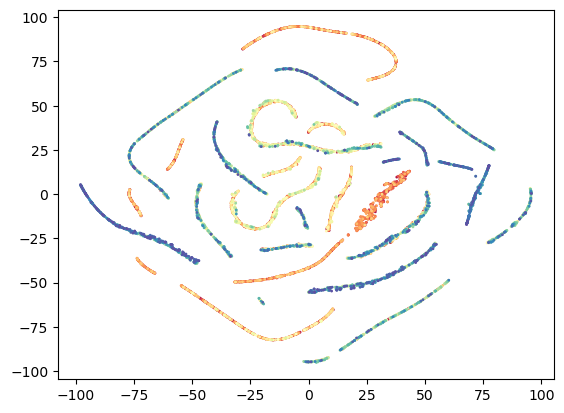

In [36]:
# T-SNE降维可视化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn
# s_num = 10000

tsne = TSNE(n_components=2, init='pca', random_state=0, n_iter=1000)
tsne.fit_transform(select_fea.cpu())
x_2dim_train = tsne.embedding_
# print(x_2dim)
# y_train = np.linspace(start = 0, stop = s_num-1, num = s_num)
lin_c = np.linspace(1, select_fea.shape[0], select_fea.shape[0])
# plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1],s=3, c=y_train, cmap=plt.cm.Spectral)
plt.scatter(x_2dim_train[:, 0], x_2dim_train[:, 1], s=1, c=lin_c,  cmap=plt.cm.Spectral)
plt.savefig('./TSNE/map_encode_selected.tiff', dpi = 300)
# plt.savefig('TSNE/data_train.svg')
plt.show()

In [ ]:
# 【邮件通知】尝试发送邮件

In [9]:
# !pip install yagmail
try:
    from Py01shared_code import get_host_name_DINO_X
    import yagmail
    subject = "👏【" + get_host_name_DINO_X() + "】编码完成通知" # save_file_path # args.pretrained_weights
    contents = "【NB15】BiNet_Encode_map2Vec.ipynb\n\n" + "【简介】本程序为编码用"+\
        "\n\n📚仅为编码完成通知" +\
        "\n\n🌈所用权重路径：" + args.pretrained_weights +\
        "\n\n🌈输出编码文件路径：" + save_file_path +\
        "\n\n💡【Tips】编码（【NB15】）后续的流程，由NB15中控制，不使用后续流程时可再NB15末尾注释。" +\
        "\n\n望坚持✊✊✊" 
    
    yag=yagmail.SMTP(user='hanyan2017@yeah.net',password='7373494259A',host='smtp.yeah.net')
    yag.send(to='723956891@qq.com',subject=subject,contents=contents)
    print('【Email】Email send success')
except:
    print('【Email】Email send fail')

【Email】Email send success


# 继续【NB16】BiNet_Matching_Iter.ipynb

In [37]:
import torch
torch.cuda.empty_cache() #使用memory_allocated前先清空一下cache
torch.cuda.memory_allocated()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()
# print(torch.cuda.memory_summary())

/root/miniconda3/lib/python3.8/site-packages/torch/cuda/memory.py:260: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [38]:
# 参数传递
pre_model_path_outside = args.pretrained_weights
# net_name_outside = net_name
arch_outside = args.arch
save_file_path_outside = save_file_path
map_grid_path_outside = map_save_path

shape_outside = shape
stride_test_outside = strid_test
crop_shape_outside = crop_shape
ex_range_outside = ex_range

mask_size_outside = mask_size
pad_mode_outside = pad_mode

num_ele_slice_outside = args.num_ele_slice

In [39]:
# print(dir())
# # 清除
# for var in list(globals().keys()):
#     if not var.startswith("_") and not var.endswith("_outside"):
#         del globals()[var]

In [40]:
# stride_test_outside = 100

In [41]:
%run ./【NB16】BiNet_Matching_Iter.ipynb

# 继续【NB25】Adaptivity

In [42]:
import torch
torch.cuda.empty_cache() #使用memory_allocated前先清空一下cache
torch.cuda.memory_allocated()
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_peak_memory_stats()
# print(torch.cuda.memory_summary())

In [43]:
# 参数传递
pre_model_path_outside = args.pretrained_weights
# net_name_outside = net_name
arch_outside = args.arch
save_file_path_outside = save_file_path
map_grid_path_outside = map_save_path
map_name_outside = map_name

shape_outside = shape
stride_test_outside = 40 # 为使得每一个都填充到，stride_test应为：ex_range*2 + mask_size
crop_shape_outside = crop_shape
ex_range_outside = 10

mask_size_outside = 20
pad_mode_outside = pad_mode

num_ele_slice_outside = args.num_ele_slice

In [44]:
# print(dir())
# # 清除
# for var in list(globals().keys()):
#     if not var.startswith("_") and not var.endswith("_outside"):
#         del globals()[var]

In [45]:
# stride_test_outside = 100

./Matching_fea/20231020印度洋1【GRET_ELE_DB_NO2_bi】_fea_consPad_DINO_3.pth

尝试读取外部变量：
pre_model_path_outside = ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth
net_name_outside = 【GRET_ELE_DB_NO2_bi】_
arch_outside = GRET_ELE_DB_NO2_bi
save_file_path_outside = ./Matching_fea/20231020大西洋1grid_1【GRET_ELE_DB_NO2_bi】_tempfea_mask_size_20DINO_3.pth
map_grid_path_outside = ./Matching_map_raw/大西洋1_gridsize1.pth
map_name_outside = 大西洋1.txt
shape_outside = (224, 224)
stride_test_outside = 40
crop_shape_outside = (224, 224)
ex_range_outside = 10
num_ele_slice_outside =  20000
外部变量存在，使用【外部配置】
已存储网格载入成功


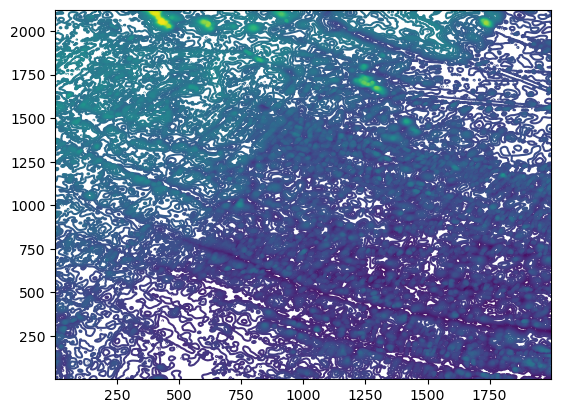

(1900, 1775, 3372500)
已读取分位数列表：per_li， 份数20000
已读取分位数列表：per_li_var， 份数20000
【预存储特征加载完成】
嵌入维度为 195
向量个数为：3372500
CPU times: user 261 ms, sys: 3.39 s, total: 3.65 s
Wall time: 3.65 s
Will run the code on one GPU.
已经启动，不再重复


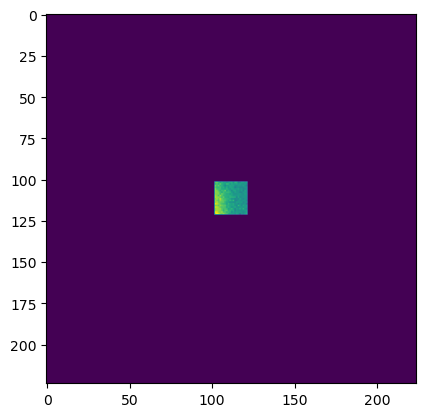

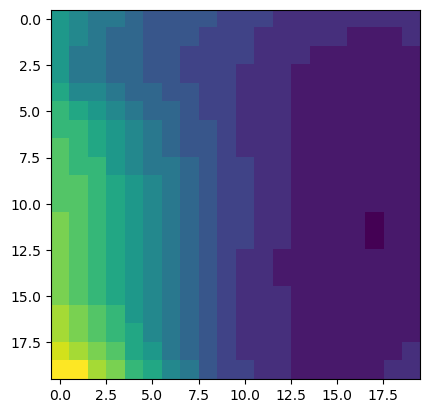

torch.Size([1, 224, 224])
torch.Size([1, 20, 20])
普通归一化与全局归一化图像
全局归一化图像


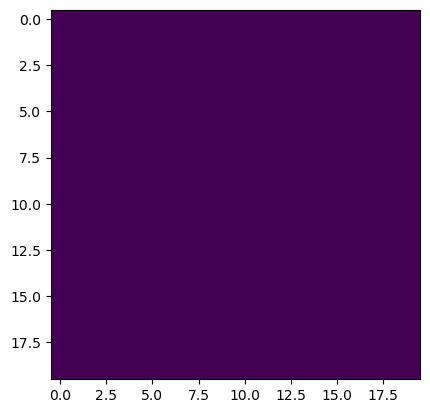

voc_k =  100  (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)
成功加载bof_voc
Take key teacher in provided checkpoint dict
Pretrained weights found at ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
预训练模型加载成功
【完成】使用预训练模型：./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth
【完成】计算节点(process group)启动完成
CPU times: user 11.6 s, sys: 22.7 s, total: 34.3 s
Wall time: 2.96 s
测试序号:2768762
输出向量尺寸：torch.Size([1, 195])
匹配预测id为： 2758109
真实标签id为： 2768762
最小特征距离为：0.005
网格偏差距离：6.708
(48, 45, 2160)


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


864000]
按range计算数据集序号完成，batchsize应为： 400
测试数量：48*45 = 2160


In [ ]:
# %run ./【NB25】Adaptivity.ipynb